<a href="https://colab.research.google.com/github/gong-aipel/AIFFEL_quest-cr/blob/main/exploration04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

print(tf.__version__)


2.18.0


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
(50000, 32, 32, 3)


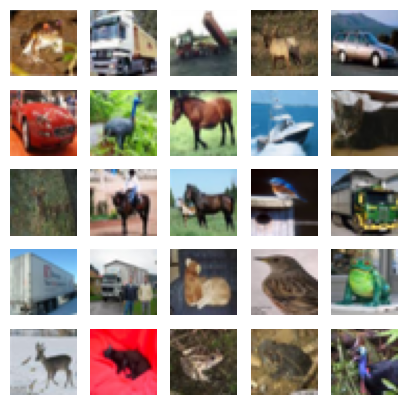

In [2]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (_, _) = cifar10.load_data()

# 정규화: [-1, 1] 범위로 조정 (tanh에 맞춤)
train_x = (train_x.astype(np.float32) - 127.5) / 127.5

print(train_x.shape)  # (50000, 32, 32, 3)

# 시각화
plt.figure(figsize=(5, 5))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow((train_x[i] + 1) / 2)
    plt.axis('off')
plt.show()


In [13]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

# 경로 설정
checkpoint_dir = os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# 디렉토리 없으면 생성
os.makedirs(checkpoint_dir, exist_ok=True)


In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))  # 8x8x256

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))  # 32x32x3

    return model


In [4]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(real_output > 0, tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(fake_output < 0, tf.float32))
    return real_accuracy, fake_accuracy


In [6]:
generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        img = (predictions[i] + 1) / 2  # [-1,1] → [0,1]
        plt.imshow(img.numpy())
        plt.axis('off')

    path = os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}.png'.format(epoch)
    plt.savefig(path)
    plt.close()


In [8]:
checkpoint_dir = os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator=generator,
                                 discriminator=discriminator,
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer)


In [9]:
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, 100])


In [10]:
generator.summary()  # 구조 체크


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16384)          │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 3)      │         4,800 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,733,504 (10.43 MB)

 Trainable params: 2,700,352 (10.30 MB)

 Non-trainable params: 33,152 (129.50 KB)

In [12]:
import os
import tensorflow as tf

# 1. 경로 설정
checkpoint_dir = os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/training_checkpoints'

# 2. 가장 최근 체크포인트 찾기
latest = tf.train.latest_checkpoint(checkpoint_dir)

# 3. 경로 출력
print("Checkpoint loaded from:", latest)

# 4. 모델 복원하려면 아래처럼 사용
# checkpoint.restore(latest)


Checkpoint loaded from: None


Epoch 1 완료, 소요 시간: 709.79초
Epoch 2 완료, 소요 시간: 699.56초
Epoch 3 완료, 소요 시간: 701.75초
Epoch 4 완료, 소요 시간: 700.32초
Epoch 5 완료, 소요 시간: 704.97초


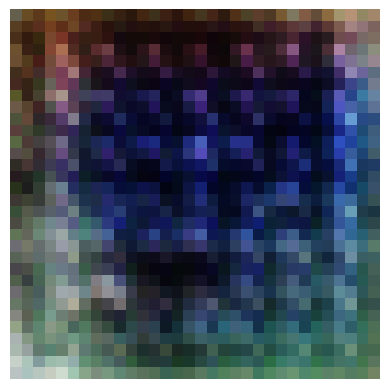

In [14]:
# ✅ DCGAN CIFAR-10 전체 구현 (Google Colab 버전)

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

# 1. 경로 설정 (Colab friendly)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
os.makedirs(checkpoint_dir, exist_ok=True)

sample_dir = './generated_samples'
os.makedirs(sample_dir, exist_ok=True)

# 2. CIFAR-10 데이터 로드 및 정규화
(train_x, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_x = (train_x.astype(np.float32) - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(50000).batch(64)

# 3. Generator 모델 정의
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

# 4. Discriminator 모델 정의
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# 5. 손실 함수 및 옵티마이저
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

# 6. Checkpoint 설정
checkpoint = tf.train.Checkpoint(generator=generator,
                                 discriminator=discriminator,
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer)

# 7. 이미지 저장 함수
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(((predictions[i] + 1) / 2.0).numpy())
        plt.axis('off')
    plt.savefig(f'./generated_samples/sample_epoch_{epoch:04d}.png')
    plt.close()

# 8. 학습 step 함수
@tf.function
def train_step(images):
    noise = tf.random.normal([64, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# 9. 학습 루프
seed = tf.random.normal([16, 100])

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        # 체크포인트 저장
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        generate_and_save_images(generator, epoch + 1, seed)
        print(f"Epoch {epoch+1} 완료, 소요 시간: {time.time() - start:.2f}초")

# 10. 학습 시작
train(train_dataset, epochs=5)

# 11. 하나 생성된 이미지 보기
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(((generated_image[0] + 1) / 2.0).numpy())
plt.axis('off')
plt.show()


회고

- 문제점 분석 (이전 훈련 결과)

학습 epoch: 5

생성 이미지 품질이 낮고 색이 퍼져 있음

판별자 accuracy가 너무 높음 → 판별자 과적합 가능성

Generator loss가 거의 줄지 않음 → 학습이 제대로 안 됨

- 시각화 예시:

판별자 accuracy 그래프가 초반부터 95% 이상 → 생성자는 발전 기회를 잃음

생성 이미지 예시: 흐릿하고 카테고리 특성이 명확하지 않음

색상 왜곡이 발생함

